In [1]:
import os
import ray
import torch
from ray.rllib.algorithms import ppo

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
from environments.al_harvest_env import al_harvest_env_creator

In [7]:
from config import get_experiment_config
num_workers = 8
use_tf_board = True
random_seed = 136838
# the below settings should only be changed if you add support for a new substrate
experiment_name = f'al_harvest'
substrate_name = 'allelopathic_harvest__open'
env_creator = al_harvest_env_creator
default_config = ppo.PPOConfig()
default_config.use_custom_reward = False

configs, exp_config, tune_config = get_experiment_config(default_config, 
                                                         '.', 
                                                         num_workers, 
                                                         experiment_name,
                                                         substrate_name,
                                                         env_creator)
env = al_harvest_env_creator(configs.env_config)

(240, 232, 3)


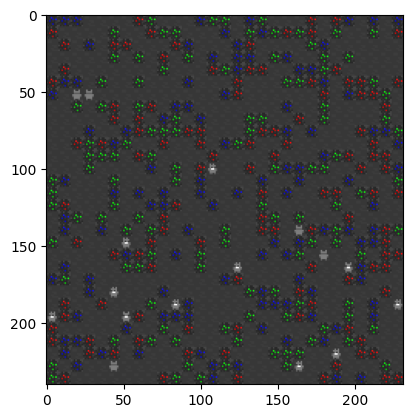

In [26]:
import matplotlib.pyplot as plt

env.reset()
obs = env.render()
print(obs.shape)
plt.imshow(obs)

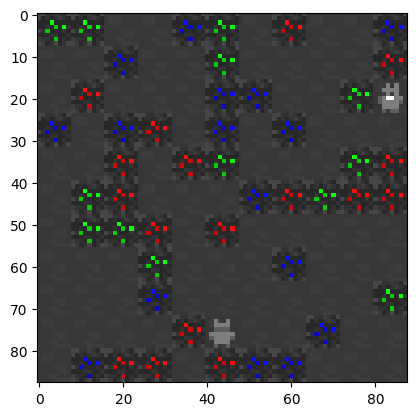

In [33]:
plt.imshow(env._env.observation()[2]['RGB'])

In [38]:
from environments.al_harvest_env import downsample_observation, find_nearest_berry, RIPE_BERRY_COLORS, UNRIPE_NONRED_COLORS

(11, 11, 3)


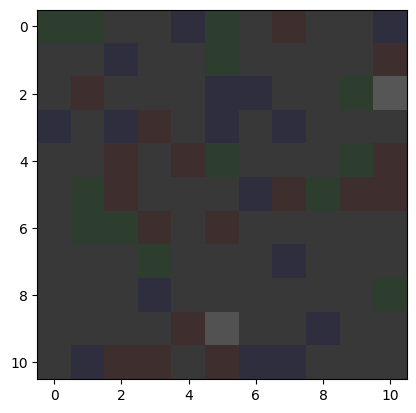

In [45]:
down_obs2 = downsample_observation(env._env.observation()[2]['RGB'], 8)
print(down_obs2.shape)
plt.imshow(down_obs2)

In [59]:
down_obs2[0,2]

array([56, 56, 56], dtype=uint8)

In [61]:
import numpy as np

(264, 264, 3)


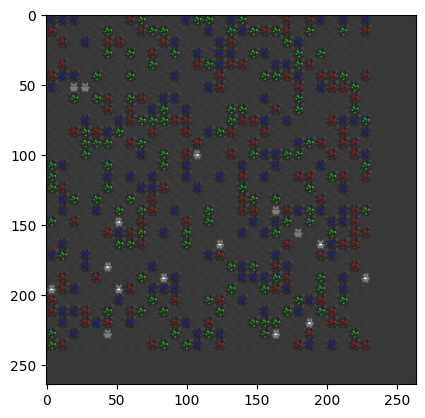

In [68]:
padded_obs = np.pad(obs, [[0, 24], [0, 32], [0, 0]], 'constant', constant_values=56)
print(padded_obs.shape)
plt.imshow(padded_obs)

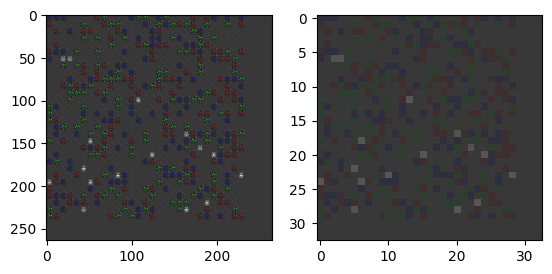

In [82]:
# have to down sample each 88x88 patch then stitch together
orig_obs = padded_obs
down_world_obs = np.zeros([padded_obs.shape[0]//8, padded_obs.shape[1]//8, 3], dtype=int)

# pad the global obs image to 264x264 with grey color
for i in range(0, 240, 88):
    for j in range(0, 232, 88):
        # print((i,j), (i+88, j+88))
        down_world_obs[i//8:i//8+11, j//8:j//8+11, :] = downsample_observation(orig_obs[i:i+88, j:j+88, :], 8)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(orig_obs)
axarr[1].imshow(down_world_obs)

# This is wrong
# down_world_obs = downsample_observation(env._env.observation()[2]['WORLD.RGB'], 8)
# print(down_world_obs.shape)
# plt.imshow(down_world_obs)
# plt.axis('off')

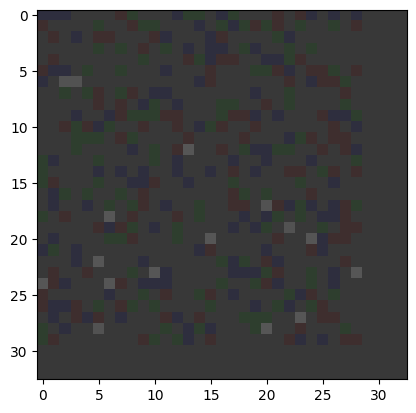

In [95]:
plt.imshow(down_world_obs)
# plt.axis('off')

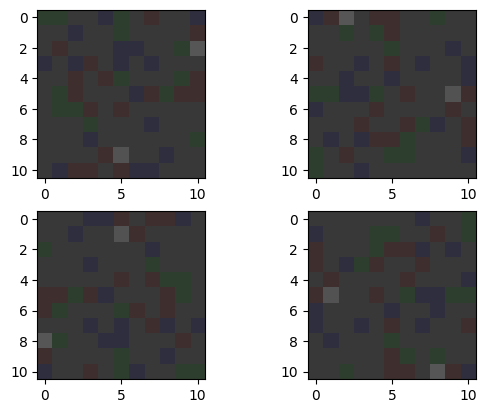

In [93]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(np.rot90(down_obs2, 0, axes=[0,1]))
axarr[0,1].imshow(np.rot90(down_obs2, 1, axes=[0,1]))
axarr[1,0].imshow(np.rot90(down_obs2, 2, axes=[0,1]))
axarr[1,1].imshow(np.rot90(down_obs2, 3, axes=[0,1]))

In [121]:
# Find each agent's glocal coordination
row, col = down_world_obs.shape[:2]
score = 9999
pos = (-1, -1, -1)
for i in range(row-10):
    for j in range(col-10):
        # even though the agent color might not be matching, we can still use the most 
        # matching patch as the true location!
        if len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 0, axes=[0,1]))[0])//3 < score:
            score = len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 0, axes=[0,1]))[0])//3
            pos = (i, j, 0)
        elif len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 1, axes=[0,1]))[0])//3 < score:
            score = len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 1, axes=[0,1]))[0])//3
            pos = (i, j, 1)
        elif len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 2, axes=[0,1]))[0])//3 < score:
            score = len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 2, axes=[0,1]))[0])//3
            pos = (i, j, 2)
        elif len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 3, axes=[0,1]))[0])//3 < score:
            score = len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 3, axes=[0,1]))[0])//3
            pos = (i, j, 3)

# at this pos[:2] position, the agent view rotated by pos[2]x90 will match the global view 
print(score, pos)



2 (7, 12, 3)


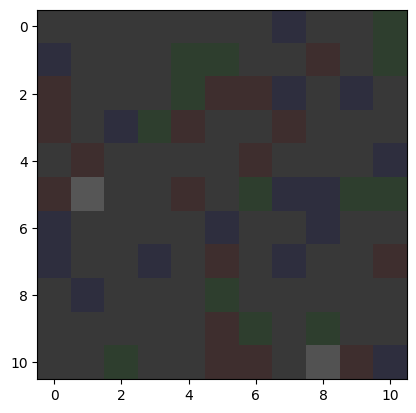

In [98]:
plt.imshow(down_world_obs[7:18, 12:23, :])

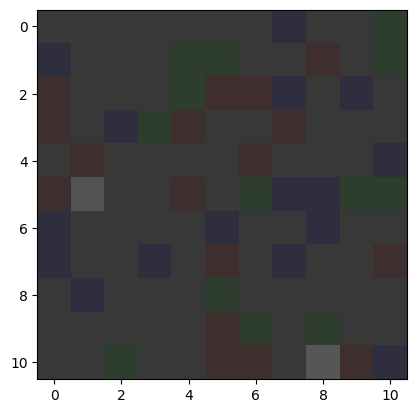

In [110]:
plt.imshow(np.rot90(down_obs2, 3, axes=[0,1]))

In [118]:
row, col = 5, 1
print(down_world_obs[7:18, 12:23, :][10, 8, 0], np.rot90(down_obs2, 3, axes=[0,1])[10, 8, 0])
len(np.where(down_world_obs[7:18, 12:23, :]- np.rot90(down_obs2, 0, axes=[0,1]))[0])//3

82 86


59

In [43]:
# for original down sample
nearest_ripe, _ = find_nearest_berry(down_obs2, RIPE_BERRY_COLORS)
nearest_unripe, _ = find_nearest_berry(down_obs2, UNRIPE_NONRED_COLORS)

print(nearest_ripe, nearest_unripe)

None (10, 6)


In [44]:
# for full world map down sample
nearest_ripe, _ = find_nearest_berry(down_world_obs, RIPE_BERRY_COLORS)
nearest_unripe, _ = find_nearest_berry(down_world_obs, UNRIPE_NONRED_COLORS)

print(nearest_ripe, nearest_unripe)

ValueError: operands could not be broadcast together with shapes (11,11) (29,30) 